## init

In [10]:
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Drop

## create embedding

In [11]:
import codecs
import os

fake_num = 50


path = "./code"
id_list = []
code_list = []

file_lst = os.listdir(path)
for file in file_lst:
    id_list.append(file[:-len(".py")])
    filepath = path + '/' + file
    with open(filepath) as f:
        code_list.append(f.read())



In [7]:
# ## 가짜 코드 생성
# fake_id_list = []
# code_list = code_list * fake_num
# for id in range(fake_num):
#     fake_id_list.extend(map(lambda x: x+str(id), id_list))

# id_list = fake_id_list
# len(id_list)

50000

In [12]:
batch_size = 8
max_len = 256
result = []
with torch.no_grad():
    for idx in range(0, len(id_list), batch_size):
        batch_input = tokenizer.batch_encode_plus(
            code_list[idx:idx+batch_size],
            return_tensors="pt",
            max_length = max_len,
            truncation = True,
            pad_to_max_length = True,
            padding=True).to(device)
        batch_output = model(**batch_input)
        cls_embedding = batch_output.last_hidden_state[:, 0, :]
        result.append(cls_embedding.to('cpu'))
        del batch_input
        del batch_output
        del cls_embedding

    ## TODO 데이터 커지면 oom 뜸


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2344: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")


In [13]:
cls_embedding = torch.cat([r for r in result]).detach().numpy()
cls_embedding.shape

(1000, 768)

## PCA

In [96]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cls_scaled= StandardScaler().fit_transform(cls_embedding)

pca = PCA(n_components=0.99)
pca.fit(cls_scaled)
cls_pca = pca.transform(cls_scaled)
cls_pca.shape

(1000, 226)

## TSNE

In [97]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
cls_tsne = tsne.fit_transform(cls_pca)
cls_tsne.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1000, 2)

## Mean shift

In [105]:
from sklearn.cluster import MeanShift
import numpy as np
from sklearn.cluster import estimate_bandwidth

bandwidth = int(estimate_bandwidth(cls_tsne))
print('bandwidth 값:', bandwidth)
meanshift= MeanShift(bandwidth=10)
label_list= meanshift.fit_predict(cls_tsne)
cluster_label = np.unique(label_list)
print('cluster labels 유형:', cluster_label)

bandwidth 값: 21
cluster labels 유형: [0 1 2 3 4 5 6 7]


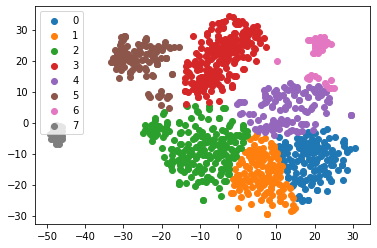

In [106]:
import matplotlib.pyplot as plt

clustered_cls = []
index_list = np.array([i for i in range(len(label_list))])
for label in cluster_label:
    labeled = cls_tsne[label_list == label]
    plt.scatter(labeled[:, 0], labeled[:, 1], label = label)
    clustered_cls.append(index_list[label_list == label])

plt.legend()


## Create Group

In [107]:
from itertools import zip_longest

min_group_member = 4
max_group_member = 8
group_list = np.array([-1] * len(id_list))
group_member_num = min(8, max(4, len(cluster_label)))
group_num = 0
cnt = 0


for member_list in zip_longest(*clustered_cls):
    for member in member_list:
        if member == None:
            continue

        cnt += 1
        group_list[member] = group_num

        if cnt % group_member_num == 0:
            group_num += 1


## find centroid

In [108]:
from sklearn.metrics import pairwise_distances_argmin_min

id_list = np.array(id_list)
closest, _ = pairwise_distances_argmin_min(meanshift.cluster_centers_, cls_tsne)
centroid_id = id_list[closest]

In [113]:
np.array(code_list)[closest]

array(['n = int(input())\nfor i in range(n):\n    a, b = map(int, input().split())\n    t = list(map(int, input().split()))\n    ans = 1\n    t2 = [0]*a\n    t2[b] = 1\n    while True:\n        c = t[0]\n        d = t2[0]\n        if c == max(t):\n            if d == 1:\n                break\n            else:\n                ans += 1\n        else:\n            t.append(c)\n            t2.append(d)\n        c = t.pop(0)\n        d = t2.pop(0)\n    print(ans)',
       'from sys import stdin\ninput = stdin.readline\n\nT = int(input())\n\nfor _ in range(T):\n    # num_doc, check_loaction\n    N, M = map(int, input().split())\n    queue = list(map(int, input().split()))\n    index = [0 for _ in range(N)]\n    index[M] = 1\n    count = 0\n\n    while queue:\n        if queue[0] == max(queue):\n            count += 1\n            if index[0] == 1:\n                print(count)\n                break\n            queue.pop(0)\n            index.pop(0)\n        else:\n            queue.appe

## Create Data

id - id_list[n]

x - cls_tsne[n:0]

y - cls_tsne[n:1]

label - label_list[n]

group - group_list[:n]

code - code_list[n]

In [109]:
import random
name_list = ['안재욱', '안재현', '안재모', '안서현', '안성기', '안보현', '이아현', '이이경', '이의정', '이원근', '이은주', '이은성', '이언정', '이기우', '이규한', '이광수', '이상우', '이상윤', '이지아', '이시원', '이재훈', '이시언', '이진욱', '이장우', '이준기', '이시영', '이정재', '이정진', '이종석', '이수경', '이수정', '이수혁', '이수민', '이승기', '이승효', '이서진', '이솜', '이소연', '이선균', '이선경', '이성재', '이다인', '이다희', '이다해', '이채영', '이천희', '이청아', '이태임', '이태성', '이태란', '이동욱', '이동건', '이나영', '이하나', '이하늬', '이현우', '이병헌', '이필립', '이범수', '이보영', '이민호', '이미연', '이민기', '이민지', '이민정', '이민호', '이문식', '이유비', '이윤지', '이요원', '이연희', '이영애', '이완', '예정화', '임주은', '임주환', '임지영', '임수정', '임창정', '임현식', '임호', '원빈', '에이미', '에릭 ', '오인헤', '오지은', '오재무', '오지호', '오만석', '오연서', '옥주현', '엄기준', '엄지원', '엄정화 ', '엄태웅', '엄현경', '온주완', '감우성', '강예원', '강경준', '강지섭', '강지환', '강소라', '강성연', '강동원', '강하늘', '강한나', '강별', '강혜정', '강미나', '기태영', '김아중', '김예원', '김원희', '김우빈', '김옥빈', '김강우', '김기범', '김규손', '김규리', '김권', '김고운', '김꽃비', '김사랑', '김상경', '김지원', '김재원', '김재욱', '김지수', '김지석', '김지훈', '김주혁', '김정은', '김정태', '김정화', '김진경', '김수현', '김수미', '김슬기', '김수로', '김승우', '김새론', '김소은', '김석훈', '김선아', '김소현', '김소연', '김성수', '김성령', '김태우', '김태희', '김동욱', '김동완', '김남길', '김남주', '김남진', '김하늘', '김희애', '김희정', '김희선', '김희철', '김향기', '김효진', '김현중', '김혜수', '김기범', '김민희', '김명민', '김민재', '김민준', '김민종', '김민서', '김민석', '김유정', '김유영', '김유리', '김윤진', '김영광', '김래원', '견미리', '구지성', '구혜선', '곽시양', '곽정은', '권상우', '권세인', '권율', '클라라', '고아성', '고아라', '고은아', '고준희', '고수', '고세원', '고소영', '고현정', '고윤', '공예지', '공승연', '공효진', '공형진', '공유', '사강', '재희', '심은하', '심은경', '심지호', '줄리엔 강', '신은수', '신구', '신세경', '신소율', '신성우', '신동욱', '신하균', '신현준', '신현빈', '신민아', '신윤주', '수애', '스테파니 리', '수현', '서예지', '소이현', '서강준', '서지석', '소지섭', '서지혜', '서준영', '서도영', '서하준', '서효림', '서현진', '소유진', '설경구', '손예진', '송일국', '송강호', '송재희', '송재림', '송지효', '송중기', '송종호', '송수현', '송승헌', '송세빈', '손태영', '송혜교', '송윤아', '성유리', '다니엘 헤니', '지진희', '지창욱', '지현우', '최우식', '최강희', '최지우', '최시원', '채정안', '채시라', '최진실', '최진혁', '최수종', '최수빈', '최송현', '최 다니엘', '최현주', '최민식', '최민수', '최유화', '최윤서', '최윤영', '최여진', '채림', '지성', '차예련', '차인표', '차승원', '차태현', '장근석', '장진영', '장신영', '장동건', '장혁', '장윤주', '주상욱', '추상미', '주지훈', '주진모', '주원', '조인성', '조은지', '조승우', '조동혁', '조한선', '조현재', '조혜정', '조혜련', '조보아', '조윤희', '조여정', '정일우', '정의철', '정우성', '정은우', '천우희', '정은채', '정겨운', '정경호', '정시아', '정재영', '전지현', '정지후', '정준호', '천정명', '정선희', '정소민', '전도연 ', '정유미', '정려원 ', '데니스 오', '남상미', '남지현', '남주혁', '남보라', '남궁민', '하지원', '하시은', '하주희', '하정우', '박예진', '박은혜', '박은빈', '박기웅', '박건형', '박상원', '박상면', '박재정', '박신양', '박신혜', '박시후', '박시연', '박수진', '박세미', '박세영', '박서준', '박소담', '박선영', '박솔미', '박진희', '박지빈', '박진주', '박하선', '박한별', '박희본', '박해일', '박해진', '박보영', '박민영', '박유환', '박용우', '박용하', '한예원', '한예슬', '한은정', '한은비', '한가인', '한고은', '한지우', '한재석', '한지혜', '한지민', '한석규', '한채아', '한채영', '한효주', '한혜진', '한혜린', '현우', '현빈', '현영', '환희', '황신혜', '황지현', '황정음', '황정민', '황수정', '황보라', '황우슬혜', '후지이 미나', '배정남', '배소은', '배두나', '배누리', '배용준', '백승희', '백소빈', '백성현', '허이재', '허준호', '홍아름', '홍종현', '홍수아', '홍수현', '홍서영', '홍충민', '홍리나', '마르코', '명세빈', '민효린', '문가영', '문근영', '문소리', '문채원', '문 메이슨', '양익준', '양진우', '양진성', '양동근', '양미경', '유아인', '유인영', '유오성', '유지태', '유준상', '유승호', '유소영', '유소라', '유다인', '유민규', '유영석', '유민 ', '윤아정', '윤은혜', '윤계상', '윤상현', '윤진희', '윤시윤', '윤정훈', '윤진서', '윤승아', '윤세인', '윤소이', '윤소희', '윤태영', '윤박', '윤현민', '윤손하', '여진구', '염정아', '연우진', '연정훈', '류시원', '류진', '류수영', '류승범', '류덕환', '류현경', '왕지혜', '왕석현', '원빛나', '하진숙', '송미주', '복문수', '권대일', '추동석', '권미진', '류도준', '하은수', '봉재진', '서상철', '사공태은', '손은식', '안병욱', '예정훈', '백현자', '이윤혁', '허상우', '윤해주', '정태영', '하수호', '임혜영', '김윤일', '강시호', '최수경', '황보수미', '배영태', '배태훈', '예경수', '허창식', '이대준', '전성아', '전우정', '박형호', '서혜미', '유효준', '노태은', '권민옥', '노명원', '권서언', '복효선', '허민태', '임재남', '권지용', '사공보영', '송소연', '류희호', '풍희우', '최성민', '사공시준', '백호재', '제갈태현', '오상혁', '전하은', '안윤혜', '문승윤', '봉진선', '신병현', '양규원', '남궁동우', '장주하', '안수정', '노채은', '정재숙', '추희자', '이다혜', '문진선', '한소원', '허은지', '황채윤', '배성민', '한승은', '유효선', '고형원', '설기연', '유명수', '고병수', '허호정', '노희욱', '설승혜', '하성혁', '문광식', '김창진', '복도하', '설인용', '남시원', '홍희경', '풍우진', '허형원', '문민정', '성정환', '홍시언', '양재은', '홍인정', '설병우', '박민옥', '사공희태', '복효준', '최서하', '고진성', '임문숙', '배수호', '남궁인준', '남궁민우', '서동현', '윤기하', '복종연', '노승호', '문민희', '백미연', '정시준', '송우연', '양은재', '사공상수', '황보재욱', '임영옥', '송규영', '손철우', '임승현', '손규현', '설준수', '정진주', '복보선', '봉용환', '제갈서정', '신철진', '송민준', '배효경', '탁만식', '이인호', '하혜경', '박원빈', '남은하', '탁남선', '신예지', '장영재', '서철우', '백창현', '장창훈', '정승아', '심연정', '표형태', '남궁동철', '윤혜연', '복용철', '오원철', '풍선화', '윤영환', '심시용', '허형기', '고서준', '조용수', '황동근', '하희재', '허민훈', '설동일', '유영옥', '최준현', '허선옥', '서대한', '정성옥', '풍윤주', '손현태', '추해일', '박호준', '남현철', '복효성', '서승혜', '이세웅', '박창희', '남영선', '봉경혜', '예영준', '황보재윤', '하정철', '노진호', '이경선', '심다정', '심소은', '심영현', '조우연', '홍진욱', '조세정', '풍광준', '조종옥', '장서원', '봉효빈', '예석희', '문홍석', '백명훈', '노태호', '허윤식', '고윤옥', '탁경식', '전경혜', '황하현', '임규철', '복승훈', '신태윤', '임원정', '전예준', '권승남', '오서연', '홍영미', '황미나', '장선숙', '예민혜', '최준재', '추성아', '탁재숙', '하영빈', '하태용', '조진아', '한현호', '권병곤', '정인정', '허은욱', '황보소미', '최혜진', '윤동수', '전영미', '추경석', '황보현준', '표소영', '강은지', '황춘수', '황혜빈', '이현정', '안종철', '류형태', '임정훈', '제갈윤준', '제갈지민', '장기정', '한주호', '윤성환', '임윤정', '한서준', '허용성', '최시욱', '남인우', '조정현', '노윤우', '정재정', '서현옥', '남궁혜원', '안태웅', '사공도현', '오동연', '황진주', '김만옥', '박윤아', '남궁주연', '안윤일', '신선아', '복희철', '송윤정', '봉명우', '사공은미', '하진혁', '탁채영', '이주혜', '제갈수빈', '백윤수', '남궁희준', '임형식', '황현옥', '안영욱', '백동영', '남해성', '예정남', '권남호', '서보경', '고창진', '백하진', '표도진', '조형우', '양해빈', '박경현', '권문정', '류태욱', '성진철', '성석훈', '남시윤', '고병곤', '이지민', '심시하', '심우영', '오순재', '풍해준', '성수빈', '허정수', '설유정', '정현성', '최경일', '사공철희', '남보경', '송용식', '표현진', '최연준', '손시하', '손현웅', '유은혜', '전승주', '한문혜', '표진희', '봉재하', '황성근', '최시연', '허현철', '윤준희', '황보인영', '이민환', '강희주', '서광일', '남세은', '최미숙', '유미선', '신광호', '신창원', '임기혁', '사공윤일', '남재영', '하시하', '성우석', '허주미', '허은옥', '탁대희', '표시웅', '성태웅', '장다은', '정주미', '조도희', '탁승용', '신문숙', '정도영', '표유빈', '제갈하현', '류병희', '신정숙', '복시원', '송상준', '조시언', '손성주', '윤형호', '예용기', '손만석', '설광선', '전영남', '김다빈', '강효남', '류범호', '정하영', '봉윤철', '표미경', '황보용성', '남궁범석', '풍재식', '안호성', '양태영', '하혜수', '황명자', '사공세은', '박우영', '전진아', '배혜준', '배주혜', '김준성', '성진하', '풍희철', '서신일', '사공영식', '박원호', '강재웅', '오규희', '황주현', '강원정', '사공형민', '강우선', '손지아', '남혜미', '추성혜', '사공영태', '백광희', '장태주', '성주혁', '설미진', '정기용', '조태기', '최영은', '이정욱', '강효성', '손도희', '오진경', '유선희', '유원빈', '사공성현', '안현기', '봉재윤', '황미진', '류만세', '허재용', '최명원', '오선옥', '심윤재', '추영윤', '예도현', '손예진', '안민철', '황진아', '성철우', '류대일', '장윤옥', '봉민영', '신기우', '허정태', '봉지연', '황영근', '전기영', '최다영', '성태진', '오민기', '송태은', '최태윤', '하세호', '한현태', '표도하', '노종현', '전선미', '오동철', '성연재', '임성철', '신보연', '추경재', '풍우성', '신영진', '예혜미', '유영기', '최민기', '백태욱', '임형민', '풍해영', '배신지', '심우철', '권정현', '조규환', '허서윤', '손원희', '전소은', '안소연', '강진옥', '임기연', '허영지', '심성혜', '정범우', '봉병수', '정정민', '복유민', '오예숙', '봉수희', '성재식', '류우준', '오우성', '남궁효경', '예미선', '노승식', '풍상혁', '홍상식', '성유경', '표하준', '정경하', '전윤아', '예해성', '제갈기훈', '정은식', '제갈광진', '류세연', '노효경', '전인욱', '봉시욱', '제갈원자', '유희호', '하창희', '한경현', '설지희', '표용수', '봉희재', '정상준', '풍서영', '조은혜', '하희영', '최재민', '신지민', '정세혁', '이도준', '장상화', '김창호', '심상혁', '심홍석', '설혜수', '제갈시원', '추기철', '양태연', '설윤빈', '류성기', '성병곤', '백인웅', '황미영', '설희호', '봉도영', '고영식', '백준성', '복상우', '노정주', '박유현', '설시원', '봉진숙', '추준현', '심성주', '남준재', '사공준희', '추영우', '안세욱', '허명선', '신은욱', '권남호', '조상학', '강현호', '박상혁', '사공효주', '류다연', '성재호', '백형우', '손하진', '복윤선', '손철정', '안신우', '사공희윤', '추유빈', '윤세린', '김준영', '최지원', '장미']
random.shuffle(name_list)

In [110]:
total_len = len(id_list)
data_list = []
for idx in range(total_len):
    data = {}
    data['id'] = id_list[idx]
    data['name'] = name_list[idx]
    data['x'] = cls_tsne[idx, 0]
    data['y'] = cls_tsne[idx, 1]
    data['label'] = label_list[idx]
    data['group'] = group_list[idx]
    data['code'] = code_list[idx]
    data_list.append(data)

data_list[0]

{'id': '29078006.',
 'name': '엄지원',
 'x': -13.925175,
 'y': 10.310214,
 'label': 3,
 'group': 0,
 'code': "TestCase=int(input())\n\nfor t in range(TestCase):\n    N,M = list(map(int,input().split(' ')))\n    importance=list()\n    queue=[]\n    for i in range(9):\n        importance.append([])\n\n    string=input()\n    for i in range(N):\n        importance[int(string[i*2])-1].append(i+1)\n\n    last=0\n    ll=int()\n    for i in range(8,-1,-1):\n        for j in range(len(importance[i])):\n            if last<importance[i][j]:\n                queue.append(importance[i][j])\n                ll=importance[i][j]\n        for j in range(len(importance[i])):\n            if last>importance[i][j]:\n                queue.append(importance[i][j])\n                ll=importance[i][j]\n        last=ll\n\n    for i in range(len(queue)):\n        if queue[i]==M+1:\n            print(i+1)\n            break"}

In [111]:
response = {}
response['data'] = data_list
response['centroid'] = centroid_id
response['labels'] = cluster_label
response['group'] = [g for g in range(group_num)]

response

{'data': [{'id': '29078006.',
   'name': '엄지원',
   'x': -13.925175,
   'y': 10.310214,
   'label': 3,
   'group': 0,
   'code': "TestCase=int(input())\n\nfor t in range(TestCase):\n    N,M = list(map(int,input().split(' ')))\n    importance=list()\n    queue=[]\n    for i in range(9):\n        importance.append([])\n\n    string=input()\n    for i in range(N):\n        importance[int(string[i*2])-1].append(i+1)\n\n    last=0\n    ll=int()\n    for i in range(8,-1,-1):\n        for j in range(len(importance[i])):\n            if last<importance[i][j]:\n                queue.append(importance[i][j])\n                ll=importance[i][j]\n        for j in range(len(importance[i])):\n            if last>importance[i][j]:\n                queue.append(importance[i][j])\n                ll=importance[i][j]\n        last=ll\n\n    for i in range(len(queue)):\n        if queue[i]==M+1:\n            print(i+1)\n            break"},
  {'id': '18500777.',
   'name': '노태호',
   'x': 19.116117,
   'y